In [2]:
import numpy as np 
import pandas as pd 
import cv2
import matplotlib.pyplot as plt 
import seaborn as sns 
import os 
from skimage import io
from skimage.color import rgb2gray
import plotly.express as px
import random
from sklearn.utils import shuffle
import shutil
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers
from keras.applications import resnet


import tensorflow_addons as tfa

#check tensorflow verison
tf.__version__

'2.11.0'

In [3]:
#get global path
global_dir = "C:/Users/david/Internship/new_testing/Data"
os.listdir(global_dir)

['deployment_wbc.py', 'model.h5', 'test', 'train', 'valid']

In [4]:
test_dir = "C:/Users/david/Internship/new_testing/Data/test"
train_dir = "C:/Users/david/Internship/new_testing/Data/train"
valid_dir = "C:/Users/david/Internship/new_testing/Data/valid"

In [5]:
# train sets
for files in os.listdir(train_dir):
    print(os.path.join(train_dir,files))

print('\n')
# valid sets
for files in os.listdir(valid_dir):
    print(os.path.join(valid_dir,files))

print('\n')
# test sets
for files in os.listdir(test_dir):
    print(os.path.join(test_dir,files))

C:/Users/david/Internship/new_testing/Data/train\adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib
C:/Users/david/Internship/new_testing/Data/train\large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa
C:/Users/david/Internship/new_testing/Data/train\normal
C:/Users/david/Internship/new_testing/Data/train\squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa


C:/Users/david/Internship/new_testing/Data/valid\adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib
C:/Users/david/Internship/new_testing/Data/valid\large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa
C:/Users/david/Internship/new_testing/Data/valid\normal
C:/Users/david/Internship/new_testing/Data/valid\squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa


C:/Users/david/Internship/new_testing/Data/test\adenocarcinoma
C:/Users/david/Internship/new_testing/Data/test\large.cell.carcinoma
C:/Users/david/Internship/new_testing/Data/test\normal
C:/Users/david/Internship/new_testing/Data/test\squamous.cell.carcinoma


In [6]:
#set globals
BATCH_SIZE = 32
EPOCHS = 50
SEED = 49
H = 300 #Height
W = 400 #Width
IMAGE_SHAPE = (460,460,3)
N_CLASSES = 4
STEPS = 50

In [7]:
# Setup GPU accelerator - configure Strategy
tpu = None
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu) #Assume TPU
except ValueError:
    strategy = tf.distribute.get_strategy() #if not TPU, set default for GPU/CPU

In [8]:
def grayscale(img):
    # Check the number of channels in the input image
    if img.shape[-1] == 3:
        # Convert color image to grayscale using the dot product formula
        gray = np.dot(img[..., :3], [0.299, 0.587, 0.114])
    else:
        # Input image is already grayscale
        gray = img
    # Add a channel dimension to the grayscale image
    gray = np.expand_dims(gray, axis=-1)
    return gray

In [9]:
train_datagen = ImageDataGenerator(dtype='float32',preprocessing_function=grayscale)
train_generator = train_datagen.flow_from_directory(train_dir,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')


valid_datagen = ImageDataGenerator(dtype='float32',preprocessing_function=grayscale)
valid_generator = valid_datagen.flow_from_directory(valid_dir,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.


In [10]:
test_datagen = ImageDataGenerator(dtype='float32',preprocessing_function=grayscale)
test_generator = test_datagen.flow_from_directory(test_dir,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

Found 315 images belonging to 4 classes.


In [11]:
with strategy.scope(): #use TPU/GPU strategy
    
    res_model = ResNet50(include_top=False, 
                         pooling='avg', 
                         weights='imagenet', 
                         input_shape = (IMAGE_SHAPE))

    for layer in res_model.layers:
        if 'conv5' not in layer.name:
            layer.trainable = False

    resnet_model = Sequential()
    resnet_model.add(res_model)
    resnet_model.add(Dropout(0.4))
    resnet_model.add(Flatten())
    resnet_model.add(BatchNormalization())
    resnet_model.add(Dropout(0.4))
    resnet_model.add(Dense(N_CLASSES, activation='softmax'))
    resnet_model.summary()

    adam_optimizer = tf.keras.optimizers.Adam(learning_rate= 0.00001, 
                                         )
    
    resnet_model.compile(optimizer=adam_optimizer, 
                         loss='categorical_crossentropy',
                         metrics=['accuracy']) #need to update to use f1 score too

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 4)                 8196      
                                                        

In [ ]:
checkpoint = ModelCheckpoint(filepath='./today_final_prediction_model.hdf5', 
                               monitor='val_loss', 
                               verbose = 1,
                               save_best_only=True)

early_stopping = EarlyStopping(verbose=1, 
                               patience=2)

history_model = resnet_model.fit(train_generator,
                               epochs = EPOCHS,
                               verbose = 1,
                               validation_data = valid_generator,
                               callbacks = [checkpoint, early_stopping])

Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 1.9880 - accuracy: 0.3197
Epoch 1: val_loss improved from inf to 1.26154, saving model to .\today_final_prediction_model.hdf5
20/20 [==============================] - 193s 9s/step - loss: 1.9880 - accuracy: 0.3197 - val_loss: 1.2615 - val_accuracy: 0.4167
Epoch 2/50
20/20 [==============================] - ETA: 0s - loss: 1.4762 - accuracy: 0.4829
Epoch 2: val_loss improved from 1.26154 to 1.07463, saving model to .\today_final_prediction_model.hdf5
20/20 [==============================] - 183s 9s/step - loss: 1.4762 - accuracy: 0.4829 - val_loss: 1.0746 - val_accuracy: 0.4861
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 1.1285 - accuracy: 0.5693
Epoch 3: val_loss improved from 1.07463 to 0.98704, saving model to .\today_final_prediction_model.hdf5
20/20 [==============================] - 188s 9s/step - loss: 1.1285 - accuracy: 0.5693 - val_loss: 0.9870 - val_accuracy: 0.4861
Epoch 4/50
20/20 [==

Epoch 26/50
20/20 [==============================] - ETA: 0s - loss: 0.0658 - accuracy: 0.9788
Epoch 26: val_loss improved from 0.42693 to 0.41341, saving model to .\today_final_prediction_model.hdf5
20/20 [==============================] - 184s 9s/step - loss: 0.0658 - accuracy: 0.9788 - val_loss: 0.4134 - val_accuracy: 0.9306
Epoch 27/50
20/20 [==============================] - ETA: 0s - loss: 0.0948 - accuracy: 0.9755
Epoch 27: val_loss improved from 0.41341 to 0.40737, saving model to .\today_final_prediction_model.hdf5
20/20 [==============================] - 191s 10s/step - loss: 0.0948 - accuracy: 0.9755 - val_loss: 0.4074 - val_accuracy: 0.9306
Epoch 28/50
20/20 [==============================] - ETA: 0s - loss: 0.0541 - accuracy: 0.9918
Epoch 28: val_loss improved from 0.40737 to 0.40378, saving model to .\today_final_prediction_model.hdf5
20/20 [==============================] - 192s 10s/step - loss: 0.0541 - accuracy: 0.9918 - val_loss: 0.4038 - val_accuracy: 0.9167
Epoch 29

In [107]:
# from tensorflow.keras.utils import load_img,img_to_array
# import keras.utils as image
# testimg="C:/Users/david/Internship/new_testing/Data/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib/ad15.png"
# img=image.load_img(testimg,target_size=(460,460))

# i=image.img_to_array(img)
# i=preprocess_input(i)
# input_arr=np.array([i])
# input_arr.shape
# # input_arr=np.expand_dims(input_arr,axis=0)
# y_predict=resnet_model.predict(input_arr)
# y_predict
# # if y_predict==0:
# #     print("The CT_Scan detected Adenocarcinoma Cancer Cell")
# # elif y_predict==1:
# #      print("The CT_Scan detected Large Cell Carcinoma Cancer Cell")
# # elif y_predict==2:
# #      print("The CT_Scan detected Normal Cell")
# # else:
# #      print("The CT_Scan detected Squamous Cell Carcinoma Cancer Cell")

In [12]:

from tensorflow import keras
model2 = keras.models.load_model('C:/Users/david/Internship/new_testing/today_final_prediction_model.hdf5')


In [13]:
accu=model2.evaluate(test_generator)
accu

10/10 [==============================] - 60s 6s/step - loss: 0.4450 - accuracy: 0.8540


[0.44501590728759766, 0.8539682626724243]

In [14]:
CLASS_NAMES=["Adinocarcinoma","Large","Normal","Squamous"]

In [19]:
train_datagen = ImageDataGenerator(dtype='float32',preprocessing_function=grayscale)
train_generator = train_datagen.flow_from_directory(train_dir,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   shuffle = False,
                                                   class_mode = 'categorical')


valid_datagen = ImageDataGenerator(dtype='float32',preprocessing_function=grayscale)
valid_generator = valid_datagen.flow_from_directory(valid_dir,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                    shuffle = False,
                                                   class_mode = 'categorical')

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.


In [22]:
test_datagen = ImageDataGenerator(dtype='float32',preprocessing_function=grayscale)
test_generator = test_datagen.flow_from_directory(test_dir,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460), shuffle = False,
                                                   class_mode = 'categorical')

Found 315 images belonging to 4 classes.


In [26]:
checkpoint = ModelCheckpoint(filepath='./deploy_prediction_model.hdf5', 
                               monitor='val_loss', 
                               verbose = 1,
                               save_best_only=True)

early_stopping = EarlyStopping(verbose=1, 
                               patience=5)

history_model = resnet_model.fit(train_generator,
                               epochs = EPOCHS,
                               verbose = 1,
                               validation_data = valid_generator,
                               callbacks = [checkpoint, early_stopping])

Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 2.0101 - accuracy: 0.2822
Epoch 1: val_loss improved from inf to 1.18028, saving model to .\deploy_prediction_model.hdf5
20/20 [==============================] - 208s 10s/step - loss: 2.0101 - accuracy: 0.2822 - val_loss: 1.1803 - val_accuracy: 0.4583
Epoch 2/50
20/20 [==============================] - ETA: 0s - loss: 1.9991 - accuracy: 0.2969
Epoch 2: val_loss improved from 1.18028 to 1.15611, saving model to .\deploy_prediction_model.hdf5
20/20 [==============================] - 205s 10s/step - loss: 1.9991 - accuracy: 0.2969 - val_loss: 1.1561 - val_accuracy: 0.4583
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 1.9724 - accuracy: 0.3328
Epoch 3: val_loss improved from 1.15611 to 1.13188, saving model to .\deploy_prediction_model.hdf5
20/20 [==============================] - 209s 10s/step - loss: 1.9724 - accuracy: 0.3328 - val_loss: 1.1319 - val_accuracy: 0.4583
Epoch 4/50
20/20 [==============

20/20 [==============================] - 111s 6s/step


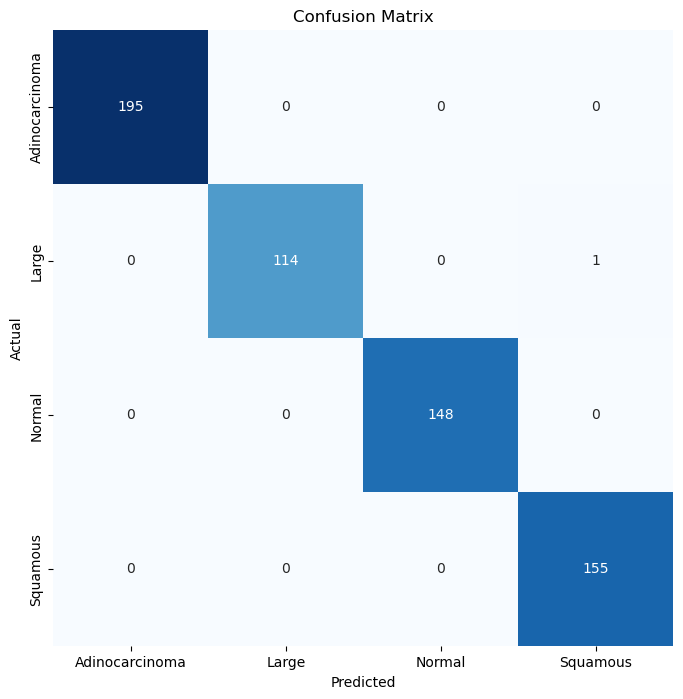

Classification Report:
----------------------
                 precision    recall  f1-score   support

Adinocarcinoma       1.00      1.00      1.00       195
         Large       1.00      0.99      1.00       115
        Normal       1.00      1.00      1.00       148
      Squamous       0.99      1.00      1.00       155

      accuracy                           1.00       613
     macro avg       1.00      1.00      1.00       613
  weighted avg       1.00      1.00      1.00       613



In [20]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report




predictions = np.argmax(model2.predict(train_generator), axis=1)

cm = tf.math.confusion_matrix(train_generator.labels, predictions)
clr = classification_report(train_generator.labels, predictions, target_names=CLASS_NAMES)


plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks= np.arange(4) + 0.5, labels=CLASS_NAMES)
plt.yticks(ticks= np.arange(4) + 0.5, labels=CLASS_NAMES)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)

10/10 [==============================] - 58s 6s/step


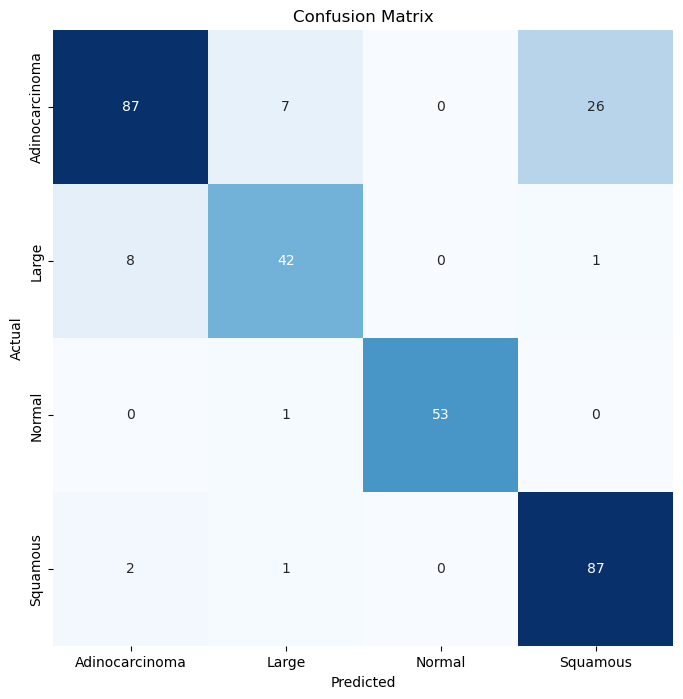

Classification Report:
----------------------
                 precision    recall  f1-score   support

Adinocarcinoma       0.90      0.72      0.80       120
         Large       0.82      0.82      0.82        51
        Normal       1.00      0.98      0.99        54
      Squamous       0.76      0.97      0.85        90

      accuracy                           0.85       315
     macro avg       0.87      0.87      0.87       315
  weighted avg       0.86      0.85      0.85       315



In [24]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report




predictions = np.argmax(model2.predict(test_generator), axis=1)

cm = tf.math.confusion_matrix(test_generator.labels, predictions)
clr = classification_report(test_generator.labels, predictions, target_names=CLASS_NAMES)


plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks= np.arange(4) + 0.5, labels=CLASS_NAMES)
plt.yticks(ticks= np.arange(4) + 0.5, labels=CLASS_NAMES)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)

In [127]:
from tensorflow.keras.utils import load_img,img_to_array
import keras.utils as image
testimg="C:/Users/david/Internship/new_testing/Data/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/sq1.png"
img=image.load_img(testimg,target_size=(460,460))

i=image.img_to_array(img)
i=preprocess_input(i)
input_arr=np.array([i])
input_arr.shape
# input_arr=np.expand_dims(input_arr,axis=0)
y_predict=model2.predict(input_arr)
y_predict
# if y_predict==0:
#     print("The CT_Scan detected Adenocarcinoma Cancer Cell")
# elif y_predict==1:
#      print("The CT_Scan detected Large Cell Carcinoma Cancer Cell")
# elif y_predict==2:
#      print("The CT_Scan detected Normal Cell")
# else:
#      print("The CT_Scan detected Squamous Cell Carcinoma Cancer Cell")

1/1 [==============================] - 0s 217ms/step


array([[0.00587462, 0.8139368 , 0.00991258, 0.17027597]], dtype=float32)

10/10 [==============================] - 55s 6s/step
Confusion Matrix
Normalized confusion matrix
Classification Report
                                                  precision    recall  f1-score   support

      adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib       0.39      0.33      0.36       120
   large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa       0.17      0.20      0.18        51
                                          normal       0.17      0.17      0.17        54
squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa       0.26      0.30      0.28        90

                                        accuracy                           0.27       315
                                       macro avg       0.25      0.25      0.25       315
                                    weighted avg       0.28      0.27      0.27       315



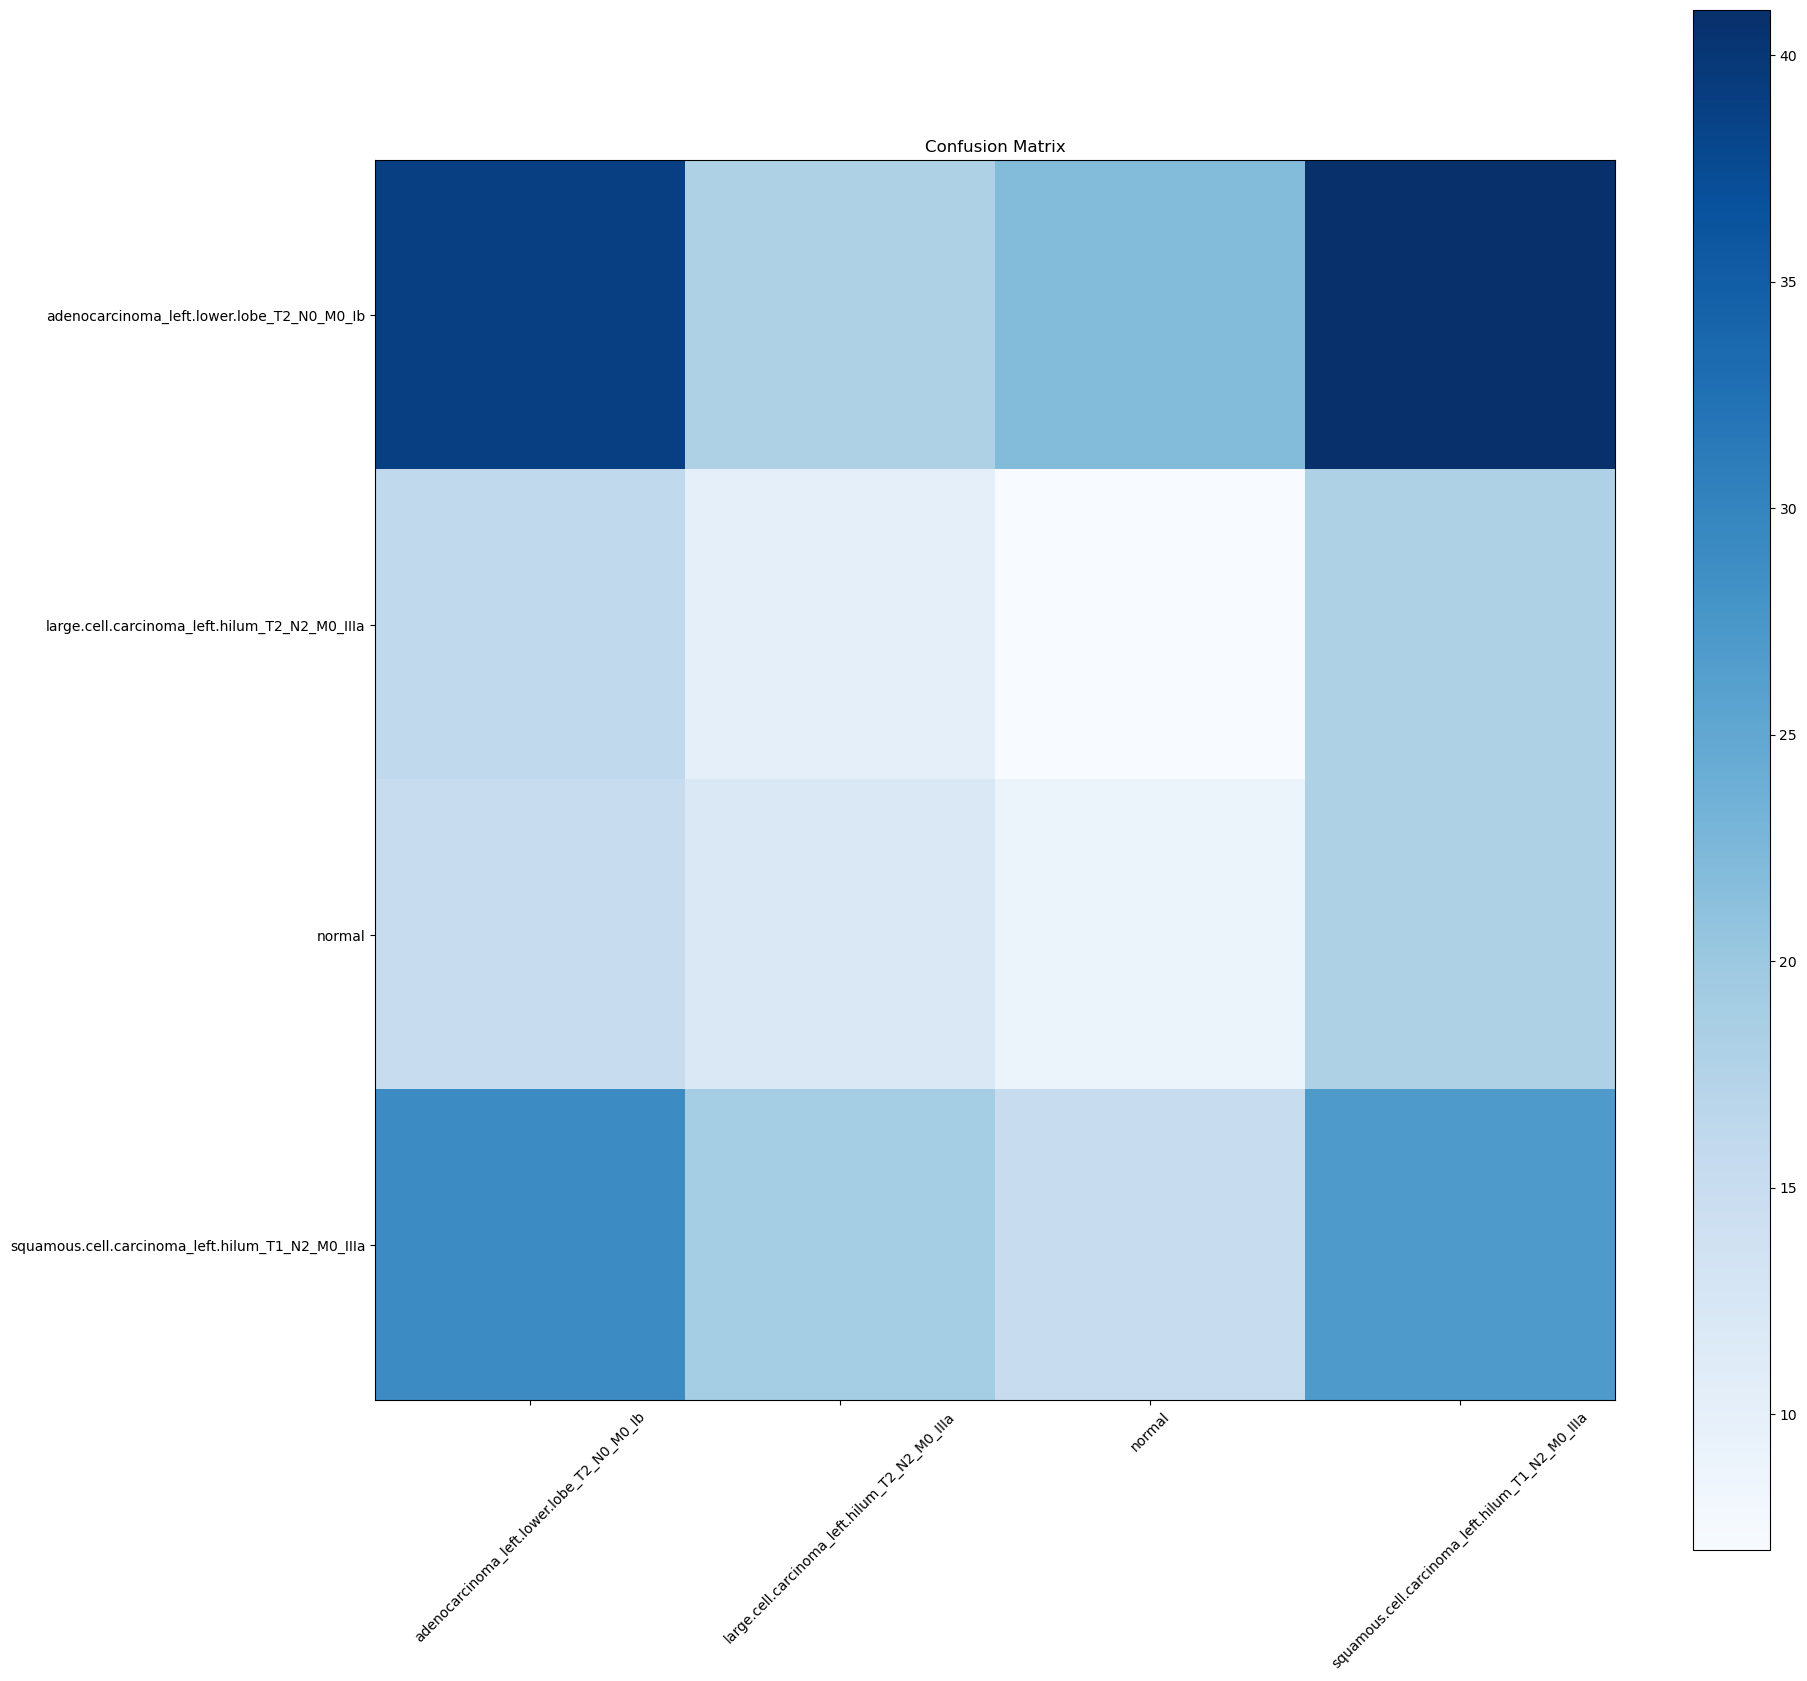

In [23]:
from tensorflow.keras.utils import load_img,img_to_array
import keras.utils as image
from tensorflow.keras.applications.resnet import preprocess_input
testimg="C:/Users/david/Internship/new_testing/testing images/adino.jfif"
img=image.load_img(testimg,target_size=(460,460))

i=image.img_to_array(img)
i=preprocess_input(i)
input_arr=np.array([i])
input_arr.shape
# input_arr=np.expand_dims(input_arr,axis=0)
y_predict=np.argmax(model.predict(input_arr))
y_predict
if y_predict==0:
    st.write("The CT_Scan detected Adenocarcinoma Cancer Cell")
elif y_predict==1:
     print("The CT_Scan detected Large Cell Carcinoma Cancer Cell")
elif y_predict==2:
     print("The CT_Scan detected Normal Cell")
else:
     print("The CT_Scan detected Squamous Cell Carcinoma Cancer Cell")

1/1 [==============================] - 0s 208ms/step
The CT_Scan detected Large Cell Carcinoma Cancer Cell


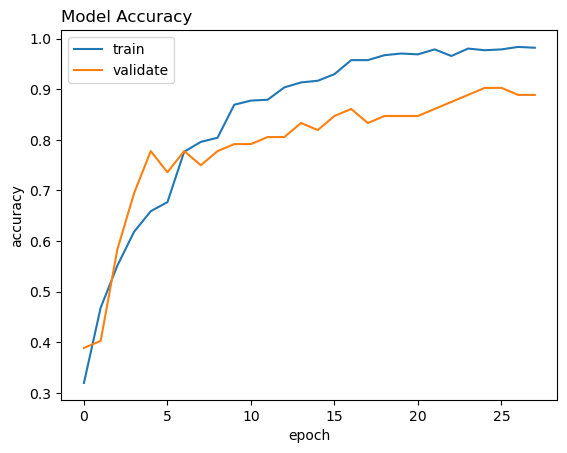

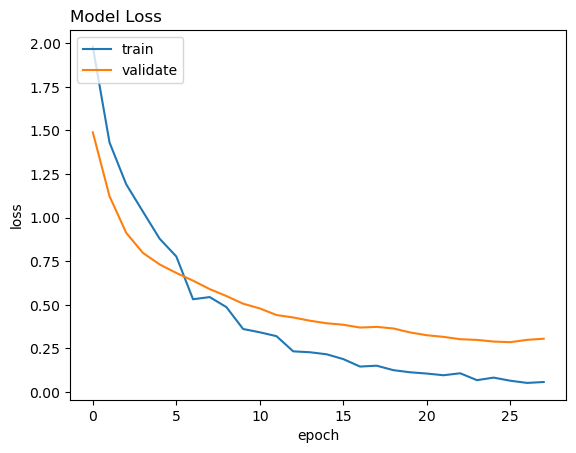

In [19]:
# graph accuracy
plt.plot(history_model.history['accuracy'])
plt.plot(history_model.history['val_accuracy'])
plt.title('Model Accuracy', loc='left')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

#graph loss
plt.plot(history_model.history['loss'])
plt.plot(history_model.history['val_loss'])
plt.title('Model Loss', loc='left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();
